<a href="https://colab.research.google.com/github/trollmannen/Data-Science/blob/main/WoW-Mpluss-Leaderboards-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
CLIENT_ID = ""
CLIENT_SECRET = ""
REGION = "eu" #"us"
LOCALE = "en_GB" #"en_US"

In [1]:
#!pip install python-blizzardapi

In [ ]:
from blizzardapi import BlizzardApi
api_client = BlizzardApi(CLIENT_ID, CLIENT_SECRET)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: Gather & Store Data

In [ ]:
import requests
def create_access_token():
  data = { 'grant_type': 'client_credentials' }
  response = requests.post(f'https://{REGION}.battle.net/oauth/token',
                           data=data, auth=(CLIENT_ID, CLIENT_SECRET))
  return response.json()['access_token']

access_token = create_access_token()

In [ ]:
def get_connected_realms_index(access_token):
  connected_realms_index = {}
  response = requests.get(f'https://{REGION}.api.blizzard.com/data/wow/search/'
                          f'connected-realm?namespace=dynamic-{REGION}'
                          f'&access_token={access_token}')
  for connected_realm in response.json()['results']:
    for realm in connected_realm['data']['realms']:
      connected_realms_index[realm['slug']] = connected_realm['data']['id']

  return pd.Series(connected_realms_index)

connected_realms_index = get_connected_realms_index(access_token)

In [ ]:
def get_dungeon_index():
  dungeon_index = {}

  response = api_client.wow.game_data.get_mythic_keystone_dungeons_index(region=REGION,
                                                                         locale=LOCALE)
  
  for dungeon in response['dungeons']:
    dungeon_index[dungeon['name'].lower()] = dungeon['id']
  
  return pd.Series(dungeon_index)

dungeon_index = get_dungeon_index()

In [ ]:
def get_periods():
  periods = []

  response = api_client.wow.game_data.get_mythic_keystone_periods_index(REGION,
                                                                        LOCALE)
  
  for period in response['periods']:
    periods.append(period['id'])

  return periods[::-1]

periods = get_periods()

In [ ]:
def get_leaderboard(crid,did,pid):
  completed_timestamp,duration,keystone_level,group_id,faction,profile_id,name,realm,spec_id = ([] for i in range(9))
  response = api_client.wow.game_data.get_mythic_keystone_leaderboard(REGION,
                                                                      LOCALE,
                                                                      crid,
                                                                      did,
                                                                      pid)
  group_id_count = 0
  for group in response['leading_groups']:
    for member in group['members']:
      completed_timestamp.append(group['completed_timestamp'])
      duration.append(group['duration'])
      keystone_level.append(group['keystone_level'])
      group_id.append(group_id_count)
      faction.append(member['faction']['type'].lower())
      profile_id.append(member['profile']['id'])
      name.append(member['profile']['name'].lower())
      realm.append(member['profile']['realm']['slug'])
      spec_id.append(member['specialization']['id'])
    group_id_count += 1

  leaderboard = leaderboard = pd.DataFrame(list(zip(completed_timestamp,duration,
                                                    keystone_level,group_id,faction,profile_id,
                                                    name,realm,spec_id)),
                              columns=['completed_timestamp','duration',
                                       'keystone_level','group_id','faction','profile_id',
                                       'name','realm','spec_id'])
  
  leaderboard['crid'] = crid
  leaderboard['did'] = did
  leaderboard['pid'] = pid

  return leaderboard

In [ ]:
leaderboards = pd.DataFrame(columns=['completed_timestamp','duration',
                                       'keystone_level','group_id','faction','profile_id',
                                       'name','realm','spec_id'])

In [ ]:
from tqdm import tqdm
for crid in tqdm(connected_realms_index.values):
  for dungeon_id in dungeon_index.values:
    leaderboards = pd.concat([get_leaderboard(crid,dungeon_id,periods[0]),
                              leaderboards], axis=0)

100%|██████████| 267/267 [40:49<00:00,  9.17s/it]


In [ ]:
def get_spec_index():
  spec_index = {}

  response = api_client.wow.game_data.get_playable_specializations_index(region=REGION,
                                                                        locale=LOCALE)
  for spec in response['character_specializations']:
    spec_index[spec['id']] = spec['name'].lower()

  return spec_index

spec_index = get_spec_index()

In [ ]:
def set_spec(spec_id):
  return spec_index[spec_id]

In [ ]:
def get_race(realm,name):
  response = api_client.wow.profile.get_character_profile_summary(REGION,
                                                                  LOCALE,
                                                                  realm,
                                                                  name)
  try:
    return response['race']['name'].lower()
  except KeyError:
    return pd.NA

In [ ]:
def get_guild(realm,name):
  response = api_client.wow.profile.get_character_profile_summary(REGION,
                                                                  LOCALE,
                                                                  realm,
                                                                  name)
  try:
    return response['guild']['name'].lower()
  except KeyError:
    return '0'

In [ ]:
api_client.wow.profile.get_character_profile_summary(REGION,
                                                     LOCALE,
                                                     'argent-dawn',
                                                     'bralfornags')['guild']['name'].lower()

In [ ]:
leaderboards.to_csv('/content/drive/MyDrive/mpluss/leaderboards.csv',index=False)

## Part 2: Clean & Organize Data

In [ ]:
leaderboards = pd.read_csv('/content/drive/MyDrive/mpluss/leaderboards.csv')

In [ ]:
leaderboards = leaderboards.drop_duplicates()

In [ ]:
leaderboards['profile_id'].nunique()

259445

In [ ]:
leaderboards['spec'] = np.vectorize(set_spec)(leaderboards['spec_id'])

## Part 3: EDA

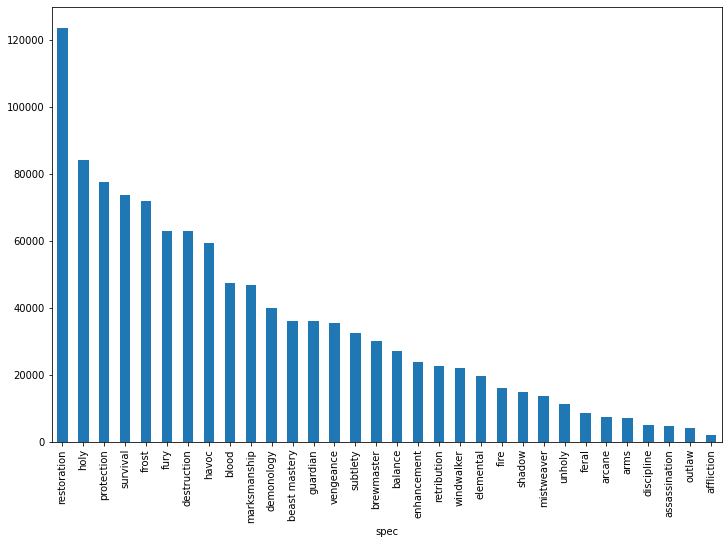

In [ ]:
plt.figure(figsize=(12,8))
leaderboards.groupby('spec').count().sort_values('name',ascending=False)['name'].plot.bar()

In [ ]:
leaderboards

,completed_timestamp,duration,keystone_level,group_id,faction,profile_id,name,realm,spec_id,crid,did,pid,spec
0,1651064483000,1761004,27,0,alliance,180129619,discíple,azjolnerub,257,1417.0,392.0,852.0,holy
1,1651064483000,1761004,27,0,alliance,202361626,shaene,aegwynn,581,1417.0,392.0,852.0,vengeance
2,1651064483000,1761004,27,0,alliance,203079165,pg,frostmane,261,1417.0,392.0,852.0,subtlety
3,1651064483000,1761004,27,0,alliance,136767090,yolcina,stormrage,267,1417.0,392.0,852.0,destruction
4,1651064483000,1761004,27,0,alliance,64764758,ismirana,blackmoore,255,1417.0,392.0,852.0,survival
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729255,1651245137000,1800799,2,351,horde,169356254,núckfutz,shadowsong,267,3666.0,375.0,852.0,destruction
3729256,1651245137000,1800799,2,351,alliance,66838701,xgdawgxzz,hellscream,66,3666.0,375.0,852.0,protection
3729257,1651245137000,1800799,2,351,alliance,253801087,alteriass,sylvanas,102,3666.0,375.0,852.0,balance
3729258,1651245137000,1800799,2,351,alliance,153578684,chapardeuse,frostmourne,260,3666.0,375.0,852.0,outlaw
